Importing Modules

In [ ]:
!pip install mapclassify
!pip install --upgrade  pysal==1.14.4
!pip install imageio

# Import modules
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import imageio
import math
import numpy as np
import rasterio
from rasterio.transform import Affine
from scipy import stats
from shapely.geometry import Polygon, box
from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity

Plotting the histogram

In [33]:
# Select the desired years
years = [2009, 2010, 2011, 2012, 2013, 2014]

In [26]:
#PLOTTING OUT THE VESSEL DATA IN A HISTOGRAM

data = r'./data/ship_data/merged_data.shp'

vessel_data = gpd.read_file(data)

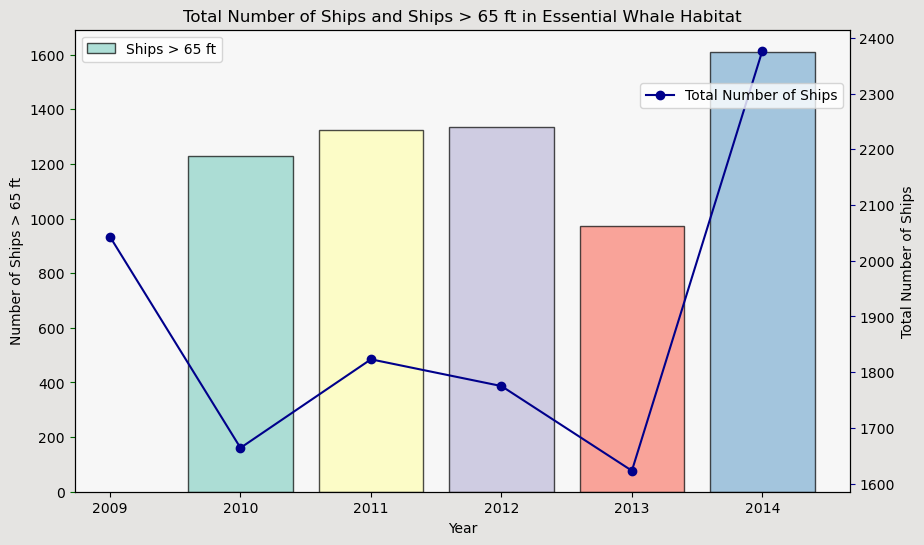

In [37]:
# Convert BaseDateTi column to datetime data type
vessel_data['BaseDateTi'] = pd.to_datetime(vessel_data['BaseDateTi'])

# Filter the DataFrame for the selected years
filtered_data = vessel_data[vessel_data['BaseDateTi'].dt.year.isin(years)]

# Group the filtered DataFrame by year and count the unique VoyageID
unique_ships = filtered_data.groupby(filtered_data['BaseDateTi'].dt.year)['VoyageID'].nunique()

# Filter the DataFrame for ships larger than 65 ft
large_ships = filtered_data[filtered_data['Length'] > 65]
large_ships_count = large_ships.groupby(large_ships['BaseDateTi'].dt.year)['VoyageID'].nunique()

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot the histogram of ships > 65 ft on the left y-axis
colors = plt.cm.Set3(range(len(large_ships_count)))
ax1.bar(large_ships_count.index, large_ships_count.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
ax1.set_ylabel('Number of Ships > 65 ft')
ax1.tick_params(axis='y', color='darkgreen')

# Plot the line plot of total number of ships on the right y-axis
ax2.plot(unique_ships.index, unique_ships.values, color='darkblue', marker='o')
ax2.set_ylabel('Total Number of Ships')
ax2.tick_params(axis='y', color='darkblue')

# Set the x-axis labels
ax1.set_xlabel('Year')

# Set the plot title
plt.title('Total Number of Ships and Ships > 65 ft in Essential Whale Habitat')

# Set the background color
fig.patch.set_facecolor('#E5E4E2')
ax1.set_facecolor('#F7F7F7')

# Show the legend for both y-axes
ax1.legend(['Ships > 65 ft'], loc='upper left')
ax2.legend(['Total Number of Ships'], loc='upper right', bbox_to_anchor=(1, 0.9))

# Display the plot
plt.show()

### Getting habitat and ship data

In [6]:
whale_habitats = gpd.read_file("./data/whaledata/WhaleHumpbackDPSs_20210421/WhaleHumpback_MexicoDPS_20210421.shp")
whale_habitats = whale_habitats[4:]
whale_habitats

,ID,SCIENAME,COMNAME,LISTENTITY,LISTSTATUS,CHSTATUS,UNIT,TAXON,LEADOFFICE,ECFR,...,PUBDATE,EFFECTDATE,AREASqKm,CREATEDATE,NOTES,INPORTURL,HABTYPE,Shape_Leng,Shape_Area,geometry
4,100054439.0,Megaptera novaeangliae,"Whale, humpback","Whale, humpback [Mexico DPS]",Threatened,Final,11 Coastal Washington,baleen whale,Office of Protected Resources,https://www.ecfr.gov/current/title-50/chapter-...,...,04/21/2021,05/21/2021,6918.432943,04/21/2021,None,https://www.fisheries.noaa.gov/inport/item/65377,marine,8.308141,0.834155,"MULTIPOLYGON (((-124.31113 46.85556, -124.3017..."
5,100054440.0,Megaptera novaeangliae,"Whale, humpback","Whale, humpback [Mexico DPS]",Threatened,Final,12 Columbia River Area,baleen whale,Office of Protected Resources,https://www.ecfr.gov/current/title-50/chapter-...,...,04/21/2021,05/21/2021,12346.450854,04/21/2021,None,https://www.fisheries.noaa.gov/inport/item/65377,marine,7.080209,1.434236,"POLYGON ((-124.28668 46.78001, -124.28668 46.7..."
6,100054441.0,Megaptera novaeangliae,"Whale, humpback","Whale, humpback [Mexico DPS]",Threatened,Final,13 Coastal Oregon,baleen whale,Office of Protected Resources,https://www.ecfr.gov/current/title-50/chapter-...,...,04/21/2021,05/21/2021,19721.003830,04/21/2021,None,https://www.fisheries.noaa.gov/inport/item/65377,marine,9.713874,2.209369,"POLYGON ((-124.03415 45.16788, -124.03335 45.1..."
7,100054442.0,Megaptera novaeangliae,"Whale, humpback","Whale, humpback [Mexico DPS]",Threatened,Final,14 Southern Oregon/Northern California,baleen whale,Office of Protected Resources,https://www.ecfr.gov/current/title-50/chapter-...,...,04/21/2021,05/21/2021,11701.198399,04/21/2021,None,https://www.fisheries.noaa.gov/inport/item/65377,marine,7.506627,1.260742,"POLYGON ((-124.96331 42.17637, -124.40622 42.1..."
8,100054443.0,Megaptera novaeangliae,"Whale, humpback","Whale, humpback [Mexico DPS]",Threatened,Final,15 California North Coast,baleen whale,Office of Protected Resources,https://www.ecfr.gov/current/title-50/chapter-...,...,04/21/2021,05/21/2021,16802.839260,04/21/2021,None,https://www.fisheries.noaa.gov/inport/item/65377,marine,10.638681,1.760866,"POLYGON ((-125.71270 40.35012, -124.39376 40.3..."
9,100054444.0,Megaptera novaeangliae,"Whale, humpback","Whale, humpback [Mexico DPS]",Threatened,Final,16 San Francisco/Monterey Bay Area,baleen whale,Office of Protected Resources,https://www.ecfr.gov/current/title-50/chapter-...,...,04/21/2021,05/21/2021,42357.114273,04/21/2021,None,https://www.fisheries.noaa.gov/inport/item/65377,marine,12.481605,4.308760,"POLYGON ((-124.13490 38.67861, -124.13490 38.6..."
10,100054445.0,Megaptera novaeangliae,"Whale, humpback","Whale, humpback [Mexico DPS]",Threatened,Final,17 California Central Coast,baleen whale,Office of Protected Resources,https://www.ecfr.gov/current/title-50/chapter-...,...,04/21/2021,05/21/2021,22968.146367,04/21/2021,None,https://www.fisheries.noaa.gov/inport/item/65377,marine,10.357546,2.271579,"POLYGON ((-121.53258 36.00000, -121.50153 35.9..."
11,100054446.0,Megaptera novaeangliae,"Whale, humpback","Whale, humpback [Mexico DPS]",Threatened,Final,18 Channel Islands Area,baleen whale,Office of Protected Resources,https://www.ecfr.gov/current/title-50/chapter-...,...,04/21/2021,05/21/2021,33652.588558,04/21/2021,None,https://www.fisheries.noaa.gov/inport/item/65377,marine,13.378821,3.274113,"POLYGON ((-120.54115 34.50091, -120.54100 34.5..."


In [7]:
proj = 3310
whale_habitats = whale_habitats.to_crs(proj)

### Grid Function

In [8]:
def create_grid(feature, shape, side_length):
    '''Create a grid consisting of either rectangles or hexagons with a specified side length that covers the extent of input feature.'''

    # Slightly displace the minimum and maximum values of the feature extent by creating a buffer
    # This decreases likelihood that a feature will fall directly on a cell boundary (in between two cells)
    # Buffer is projection dependent (due to units)
    feature = feature.buffer(20)

    # Get extent of buffered input feature
    min_x, min_y, max_x, max_y = feature.total_bounds


    # Create empty list to hold individual cells that will make up the grid
    cells_list = []

    # Create grid of squares if specified
    if shape in ["square", "rectangle", "box"]:

        # Adapted from https://james-brennan.github.io/posts/fast_gridding_geopandas/
        # Create and iterate through list of x values that will define column positions with specified side length
        for x in np.arange(min_x - side_length, max_x + side_length, side_length):

            # Create and iterate through list of y values that will define row positions with specified side length
            for y in np.arange(min_y - side_length, max_y + side_length, side_length):

                # Create a box with specified side length and append to list
                cells_list.append(box(x, y, x + side_length, y + side_length))


    # Otherwise, create grid of hexagons
    elif shape == "hexagon":

        # Set horizontal displacement that will define column positions with specified side length (based on normal hexagon)
        x_step = 1.5 * side_length

        # Set vertical displacement that will define row positions with specified side length (based on normal hexagon)
        # This is the distance between the centers of two hexagons stacked on top of each other (vertically)
        y_step = math.sqrt(3) * side_length

        # Get apothem (distance between center and midpoint of a side, based on normal hexagon)
        apothem = (math.sqrt(3) * side_length / 2)

        # Set column number
        column_number = 0

        # Create and iterate through list of x values that will define column positions with vertical displacement
        for x in np.arange(min_x, max_x + x_step, x_step):

            # Create and iterate through list of y values that will define column positions with horizontal displacement
            for y in np.arange(min_y, max_y + y_step, y_step):

                # Create hexagon with specified side length
                hexagon = [[x + math.cos(math.radians(angle)) * side_length, y + math.sin(math.radians(angle)) * side_length] for angle in range(0, 360, 60)]

                # Append hexagon to list
                cells_list.append(Polygon(hexagon))

            # Check if column number is even
            if column_number % 2 == 0:

                # If even, expand minimum and maximum y values by apothem value to vertically displace next row
                # Expand values so as to not miss any features near the feature extent
                min_y -= apothem
                max_y += apothem

            # Else, odd
            else:

                # Revert minimum and maximum y values back to original
                min_y += apothem
                max_y -= apothem

            # Increase column number by 1
            column_number += 1

    # Else, raise error
    else:
        raise Exception("Specify a rectangle or hexagon as the grid shape.")

    # Create grid from list of cells
    grid = gpd.GeoDataFrame(cells_list, columns = ['geometry'], crs = proj)

    # Create a column that assigns each grid a number
    grid["Grid_ID"] = np.arange(len(grid))

    # Return grid
    return grid

In [9]:
side_length = 20_000 # meters
shape = 'square'

### Plot West Coast Grid

### Spatial Join - Point Density

In [ ]:
for year in years:
    ## Get ship data
    ship_points = gpd.read_file(f"data/ship_data/vessel_{year}_final.shp")
    ship_points["Point_ID"] = np.arange(ship_points.shape[0])
    ship_points = ship_points.to_crs(proj)

    ## Create Grid
    west_coast_grid = create_grid(feature = ship_points, shape = shape, side_length = side_length)

    ## Spatial Join - Point Density
    ships_cell = gpd.sjoin(ship_points, west_coast_grid, how = "inner", predicate = "intersects")
    ships_cell = ships_cell.drop_duplicates(subset = ['Point_ID']).reset_index(drop = True)

    count_field = "Count"
    ships_cell[count_field] = 1 

    ships_cell = ships_cell.groupby('Grid_ID').agg({count_field:'sum'})
    west_coast_grid = west_coast_grid.merge(ships_cell, on = 'Grid_ID', how = "left")

    west_coast_grid[count_field] = west_coast_grid[count_field].fillna(0)
    west_coast_grid[count_field] = west_coast_grid[count_field].astype(int)
    west_coast_grid[west_coast_grid['Count'] != 0]

    ## Export
    west_coast_grid.to_file(f"./data/density_data/ships_density_{year}.shp")

### Grabbing all the shapefiles, adding them to a Gpd. Converting them all to a common crs for plotting

In [16]:
ship_density_2009 = gpd.read_file('./data/density_data/ships_density_2009.shp')
ship_density_2010 = gpd.read_file('./data/density_data/ships_density_2010.shp')
ship_density_2011 = gpd.read_file('./data/density_data/ships_density_2011.shp')
ship_density_2012 = gpd.read_file('./data/density_data/ships_density_2012.shp')
ship_density_2013 = gpd.read_file('./data/density_data/ships_density_2013.shp')
ship_density_2014 = gpd.read_file('./data/density_data/ships_density_2014.shp')

whale = gpd.read_file('./data/whaledata/Num_Whales.shp')
us = gpd.read_file('./data/ship_data/us_states/cb_2022_us_state_500k.shp')

# Select states of interest for map display
westcoast = us[us["STUSPS"].isin(["OR", "CA", "WA", "NV"])]


proj_wgs = 4326
whale_wgs = whale.to_crs(proj_wgs)
westcoast_wgs = westcoast.to_crs(proj_wgs)
ship_2009_wgs = ship_density_2009.to_crs(proj_wgs)
ship_2010_wgs = ship_density_2010.to_crs(proj_wgs)
ship_2011_wgs = ship_density_2011.to_crs(proj_wgs)
ship_2012_wgs = ship_density_2012.to_crs(proj_wgs)
ship_2013_wgs = ship_density_2013.to_crs(proj_wgs)
ship_2014_wgs = ship_density_2014.to_crs(proj_wgs)




## Setting Classification Bins

In [38]:
class_bins = dict(bins=[1_000, 5_000, 10_000, 20_000, 50_000])

## Plotting 2009 map

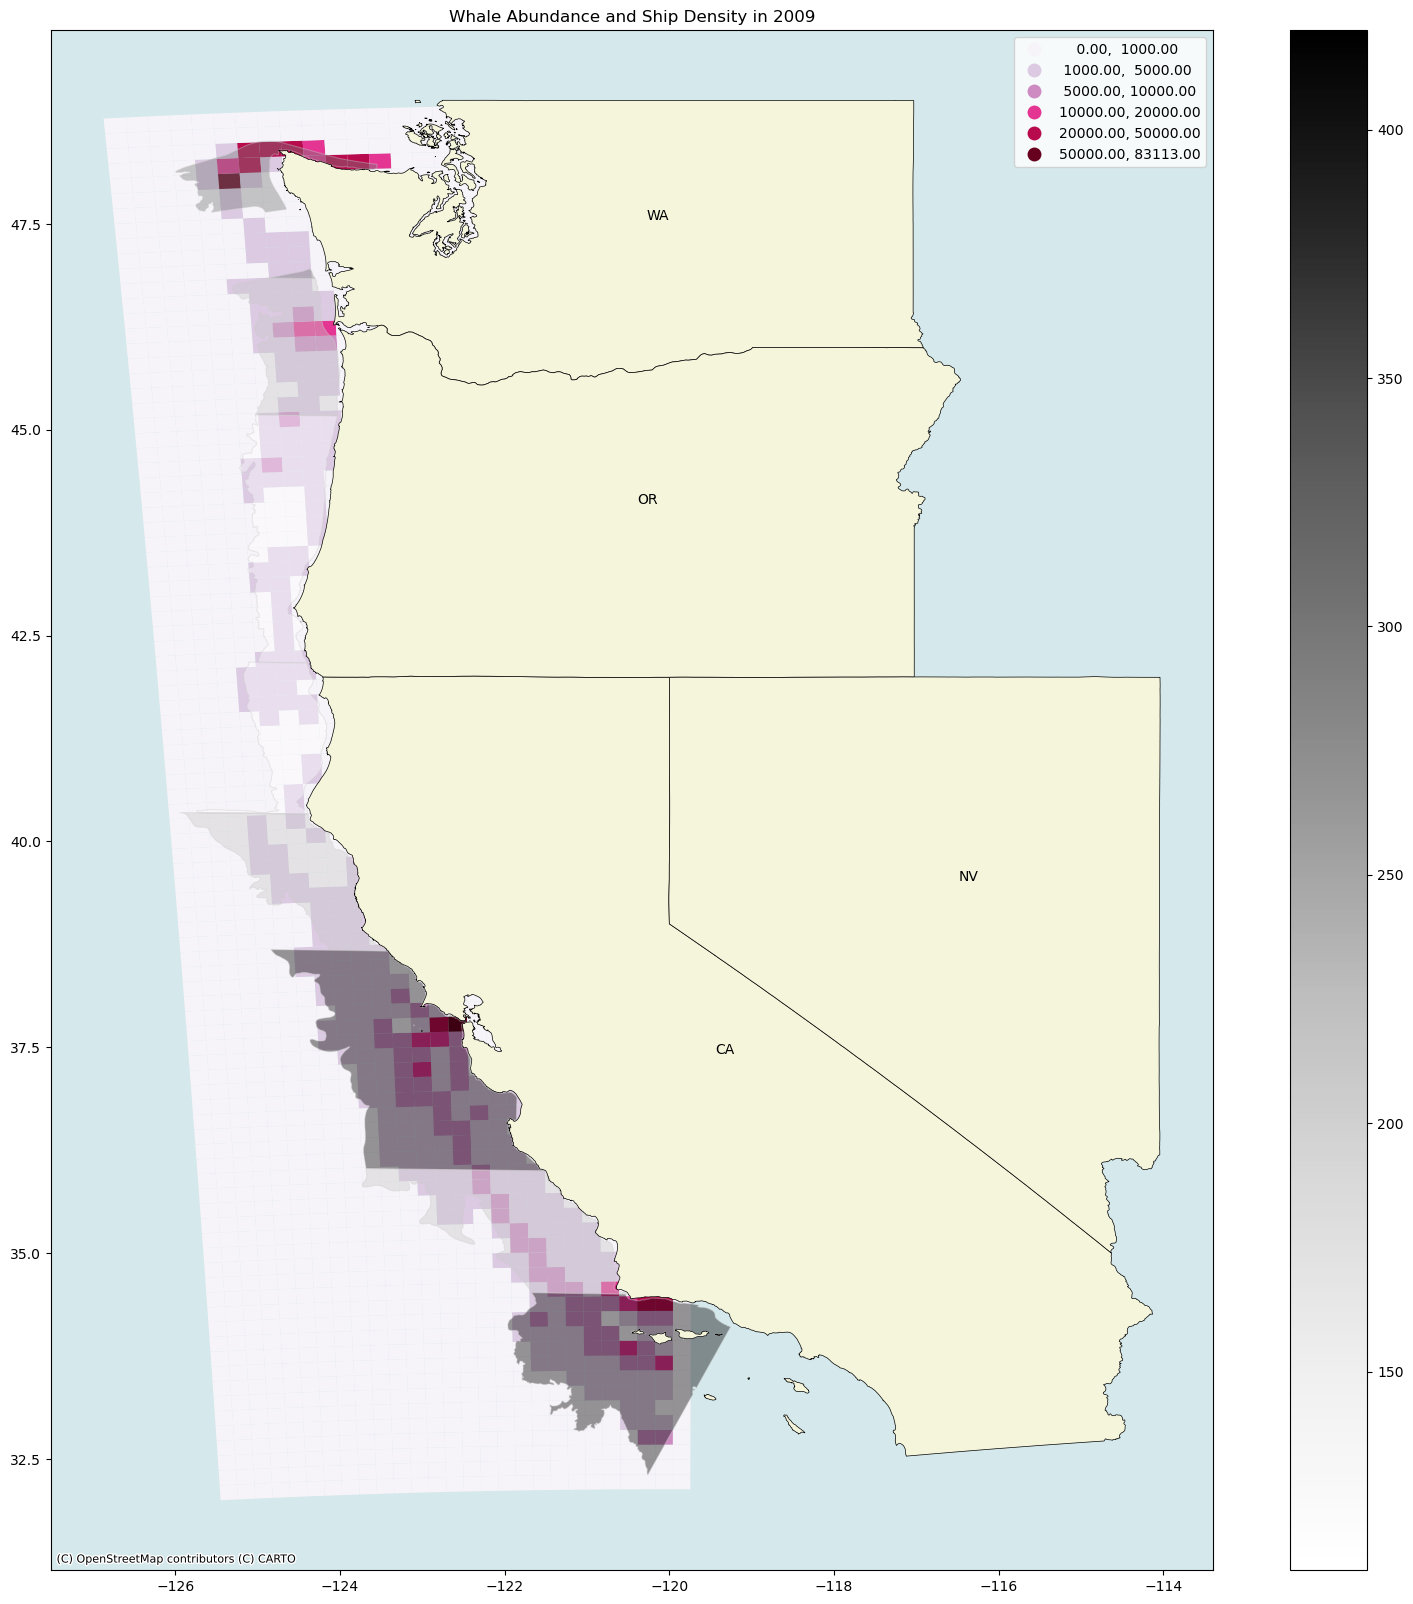

In [39]:
#2009 DENSITY 


# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(20, 20))



# Plot ship data
ship_2009_wgs.plot(ax=ax, column="Count", cmap="PuRd", linewidth=0.0, alpha=1, legend=True, scheme='User_Defined', classification_kwds=class_bins)

# Plot habitat data
whale_wgs.plot(column='2009', cmap='Greys', linewidth=0.8, alpha=0.4, ax=ax, edgecolor='0.8', legend=True)

westcoast_wgs.plot(ax=ax, marker='o', color='beige', edgecolor='black', linewidth=0.5, markersize=1)
# Add labels
for idx, row in westcoast_wgs.iterrows():
    centroid = row['geometry'].centroid
    name = row['STUSPS']
    ax.annotate(name, xy=(centroid.x, centroid.y), xytext=(10, 10), textcoords='offset points')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,zoom = 6, reset_extent = True)
# Set plot title
ax.set_title('Whale Abundance and Ship Density in 2009')

# Save the plot as a JPG file
plt.savefig('result_2009.jpg')

# Display the plot
plt.show()

## Plotting 2010

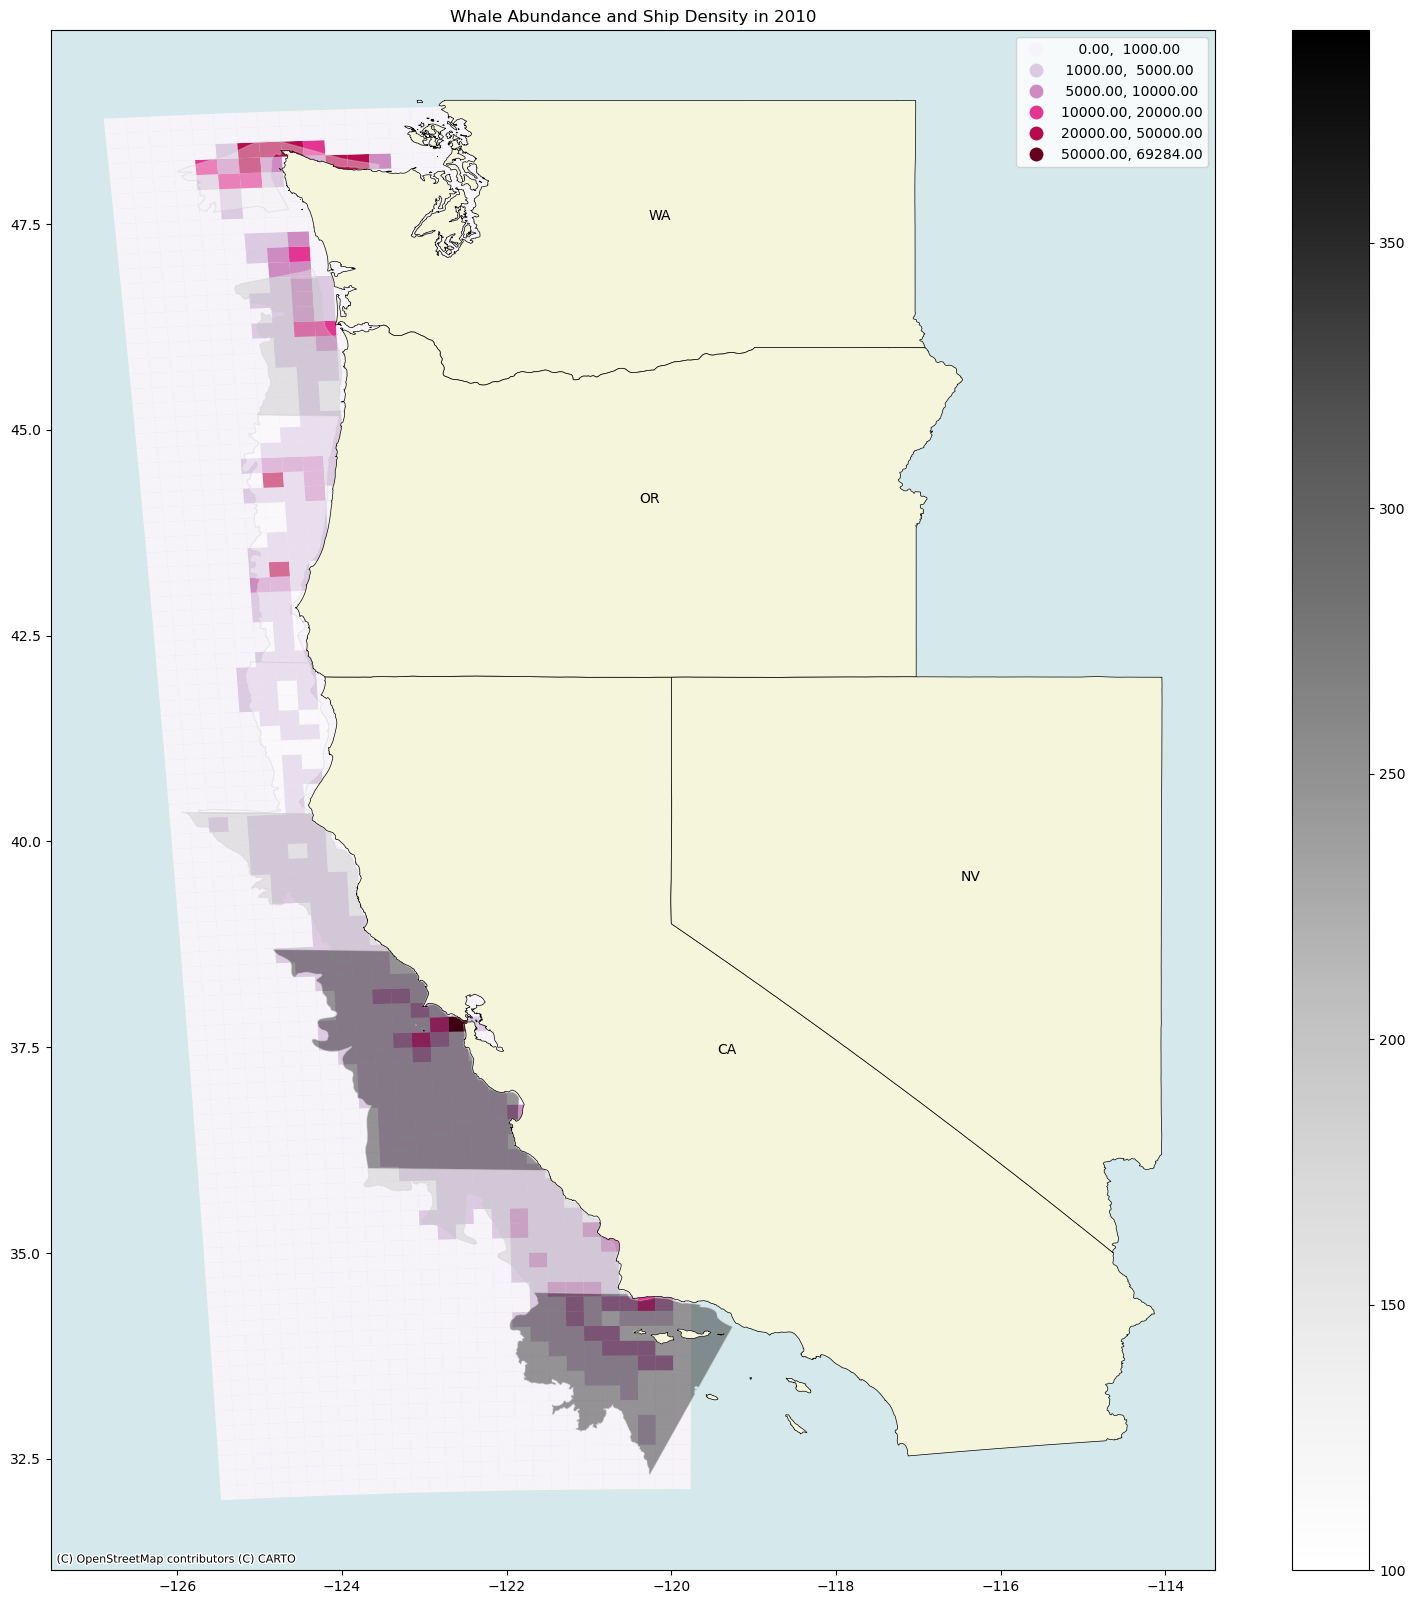

In [40]:
#2010 DENSITY 

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot 2010 ship data
ship_2010_wgs.plot(ax=ax, column="Count", cmap="PuRd", linewidth=0.0, alpha=1, legend=True, scheme='User_Defined', classification_kwds=class_bins)

# Plot habitat data
whale_wgs.plot(column='2010', cmap='Greys', linewidth=0.8, alpha=0.4, ax=ax, edgecolor='0.8', legend=True)

westcoast_wgs.plot(ax=ax, marker='o', color='beige', edgecolor='black', linewidth=0.5, markersize=1)
# Add labels
for idx, row in westcoast_wgs.iterrows():
    centroid = row['geometry'].centroid
    name = row['STUSPS']
    ax.annotate(name, xy=(centroid.x, centroid.y), xytext=(10, 10), textcoords='offset points')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,zoom = 6, reset_extent = True)
# Set plot title
ax.set_title('Whale Abundance and Ship Density in 2010')

# Save the plot as a JPG file
plt.savefig('result_2010.jpg')

# Display the plot
plt.show()


## Plotting 2011

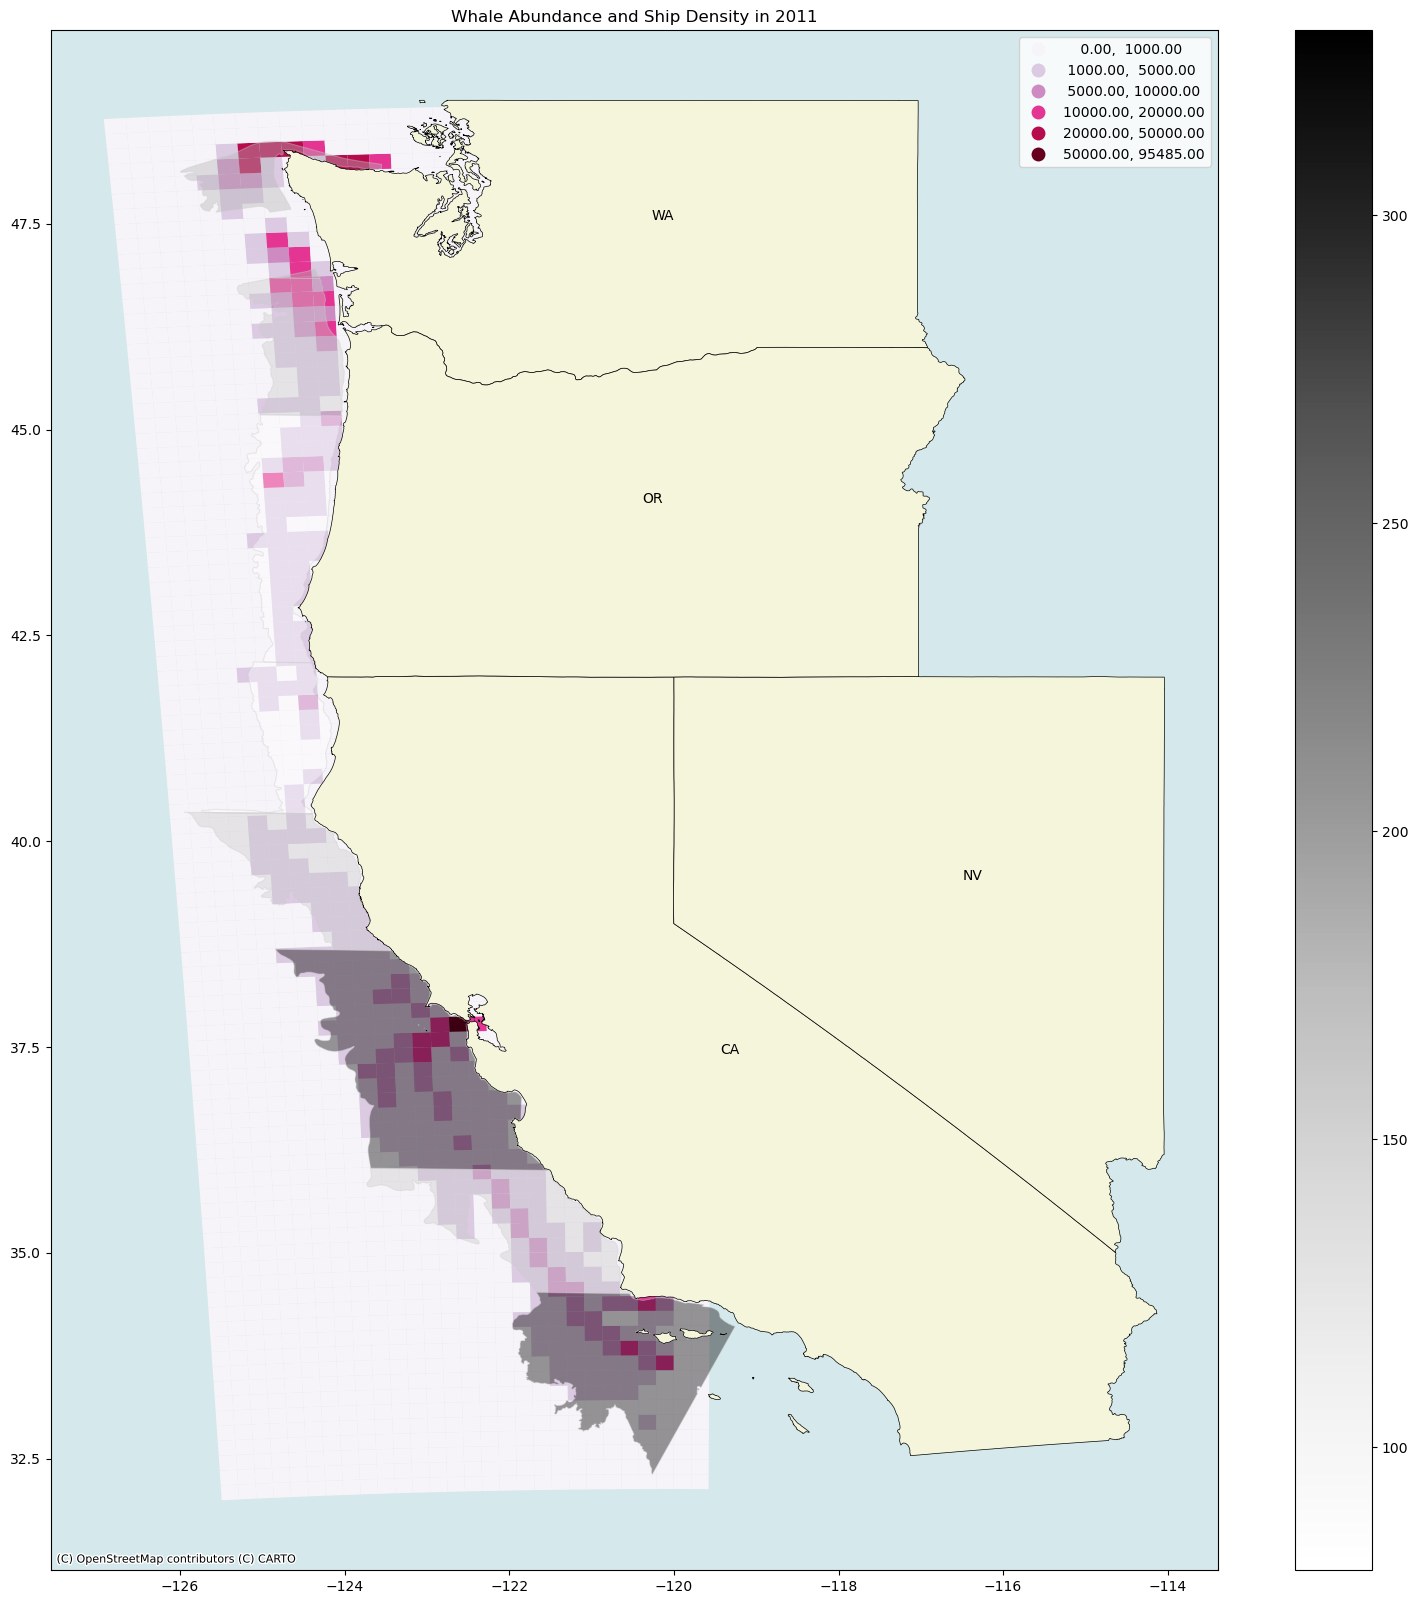

In [41]:
#2011 DENSITY 

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot 2011 ship data
ship_2011_wgs.plot(ax=ax, column="Count", cmap="PuRd", linewidth=0.0, alpha=1, legend=True, scheme='User_Defined', classification_kwds=class_bins)

# Plot habitat data
whale_wgs.plot(column='2011', cmap='Greys', linewidth=0.8, alpha=0.4, ax=ax, edgecolor='0.8', legend=True)

westcoast_wgs.plot(ax=ax, marker='o', color='beige', edgecolor='black', linewidth=0.5, markersize=1)
# Add labels
for idx, row in westcoast_wgs.iterrows():
    centroid = row['geometry'].centroid
    name = row['STUSPS']
    ax.annotate(name, xy=(centroid.x, centroid.y), xytext=(10, 10), textcoords='offset points')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,zoom = 6, reset_extent = True)
# Set plot title
ax.set_title('Whale Abundance and Ship Density in 2011')

# Save the plot as a JPG file
plt.savefig('result_2011.jpg')

# Display the plot
plt.show()

## Plotting 2012

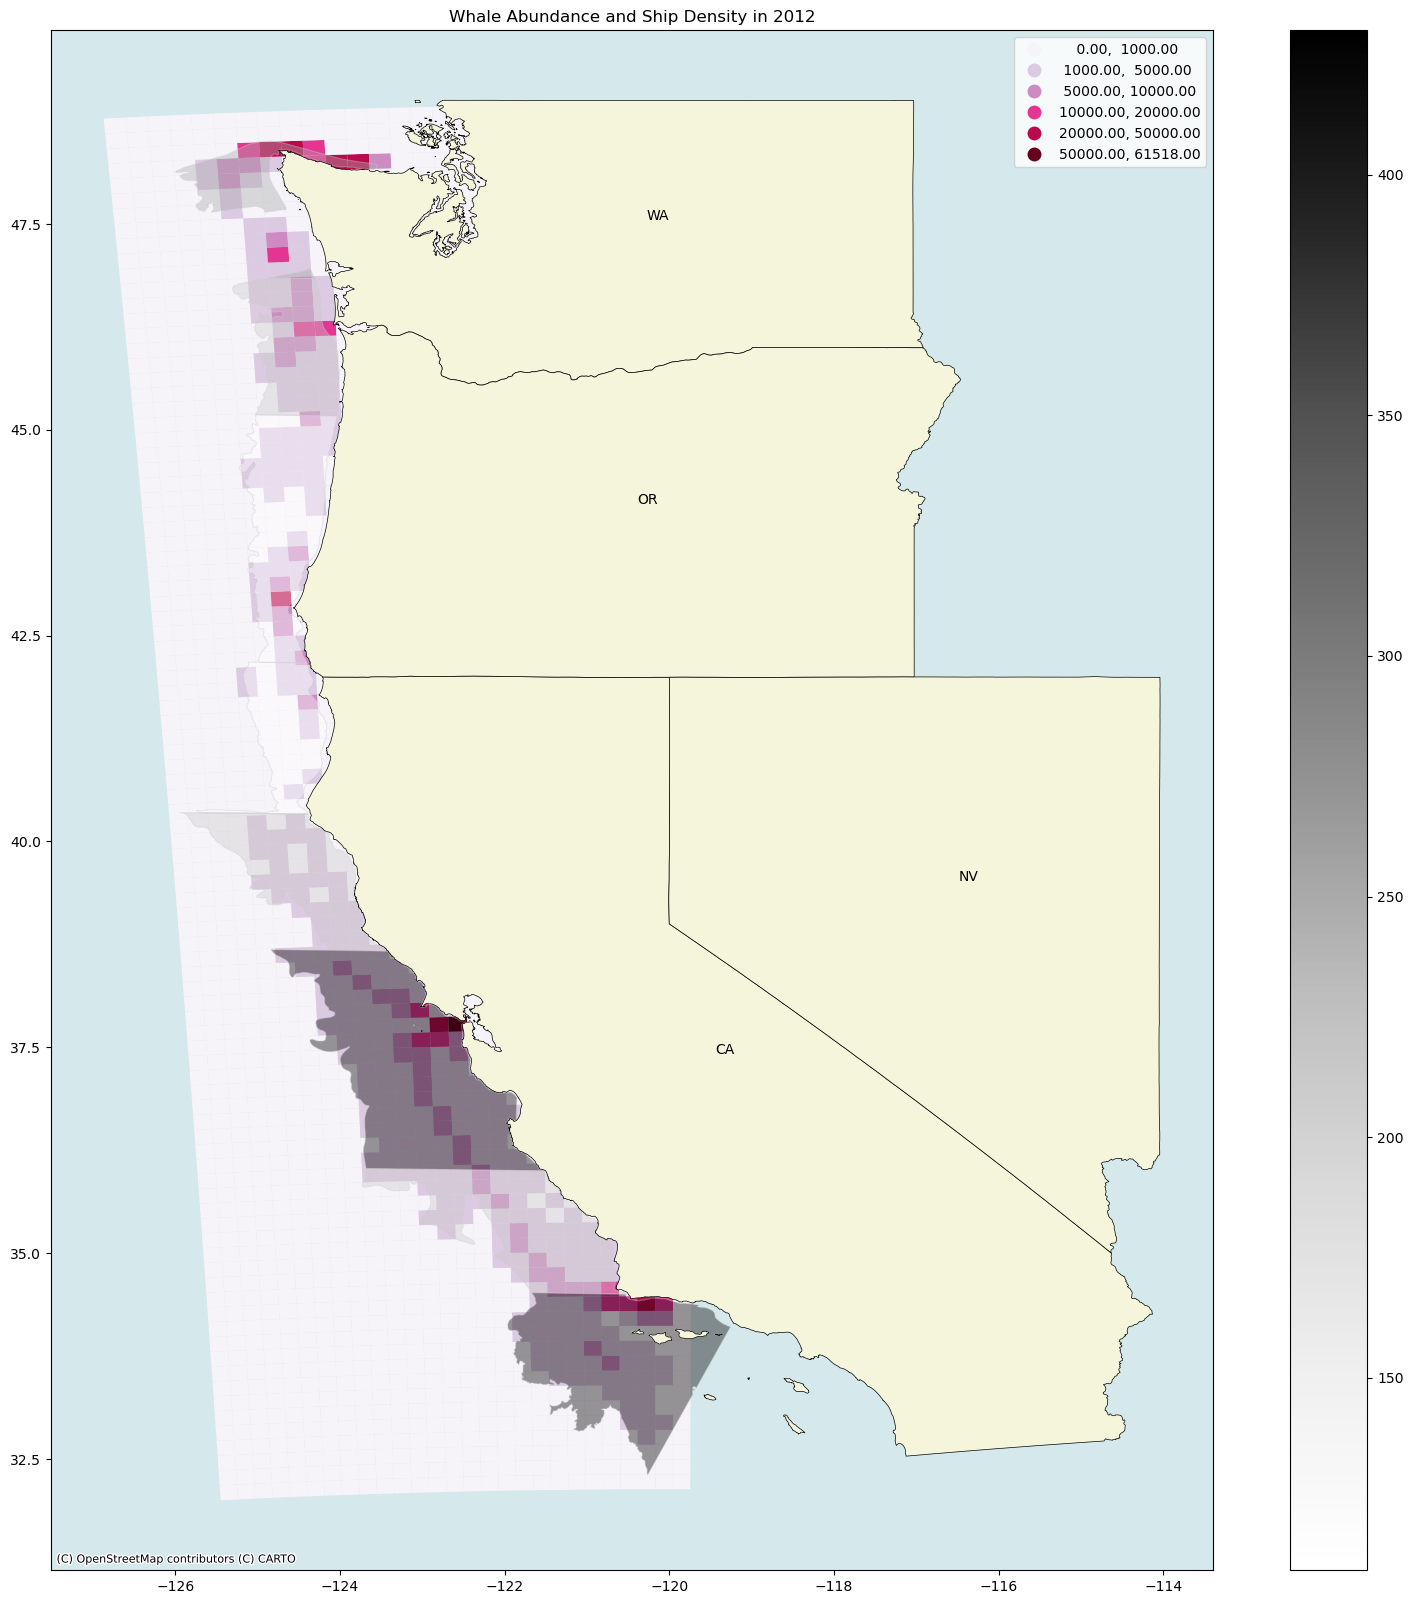

In [42]:
#2012 DENSITY 

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot 2012 ship data
ship_2012_wgs.plot(ax=ax, column="Count", cmap="PuRd", linewidth=0.0, alpha=1, legend=True, scheme='User_Defined', classification_kwds=class_bins)

# Plot habitat data
whale_wgs.plot(column='2012', cmap='Greys', linewidth=0.8, alpha=0.4, ax=ax, edgecolor='0.8', legend=True)

westcoast_wgs.plot(ax=ax, marker='o', color='beige', edgecolor='black', linewidth=0.5, markersize=1)
# Add labels
for idx, row in westcoast_wgs.iterrows():
    centroid = row['geometry'].centroid
    name = row['STUSPS']
    ax.annotate(name, xy=(centroid.x, centroid.y), xytext=(10, 10), textcoords='offset points')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,zoom = 6, reset_extent = True)
# Set plot title
ax.set_title('Whale Abundance and Ship Density in 2012')

# Save the plot as a JPG file
plt.savefig('result_2012.jpg')

# Display the plot
plt.show()

## Plotting 2013

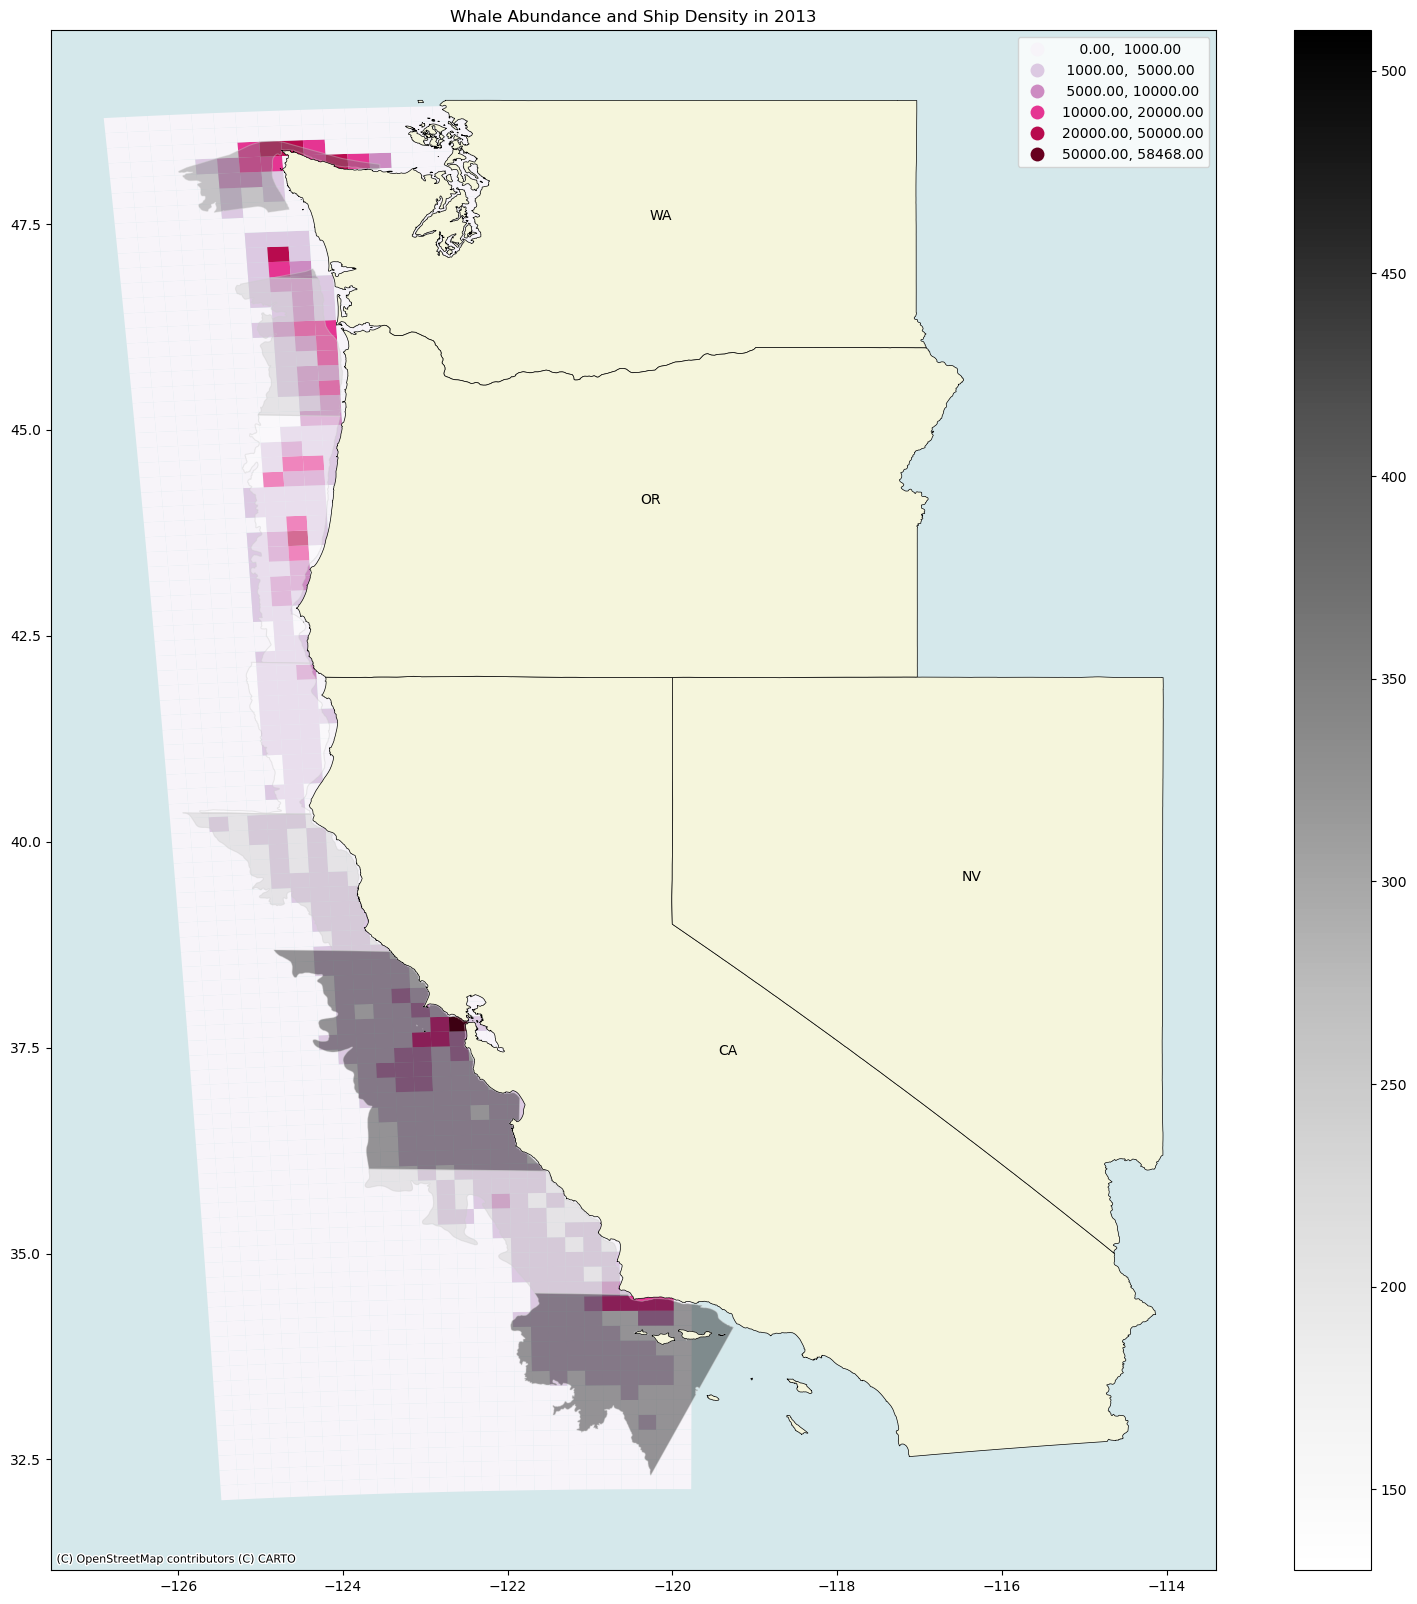

In [43]:
#2013 DENSITY 

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot 2013 ship data
ship_2013_wgs.plot(ax=ax, column="Count", cmap="PuRd", linewidth=0.0, alpha=1, legend=True, scheme='User_Defined', classification_kwds=class_bins)

# Plot habitat data
whale_wgs.plot(column='2013', cmap='Greys', linewidth=0.8, alpha=0.4, ax=ax, edgecolor='0.8', legend=True)

westcoast_wgs.plot(ax=ax, marker='o', color='beige', edgecolor='black', linewidth=0.5, markersize=1)
# Add labels
for idx, row in westcoast_wgs.iterrows():
    centroid = row['geometry'].centroid
    name = row['STUSPS']
    ax.annotate(name, xy=(centroid.x, centroid.y), xytext=(10, 10), textcoords='offset points')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,zoom = 6, reset_extent = True)
# Set plot title
ax.set_title('Whale Abundance and Ship Density in 2013')

# Save the plot as a JPG file
plt.savefig('result_2013.jpg')

# Display the plot
plt.show()

## Plotting 2014

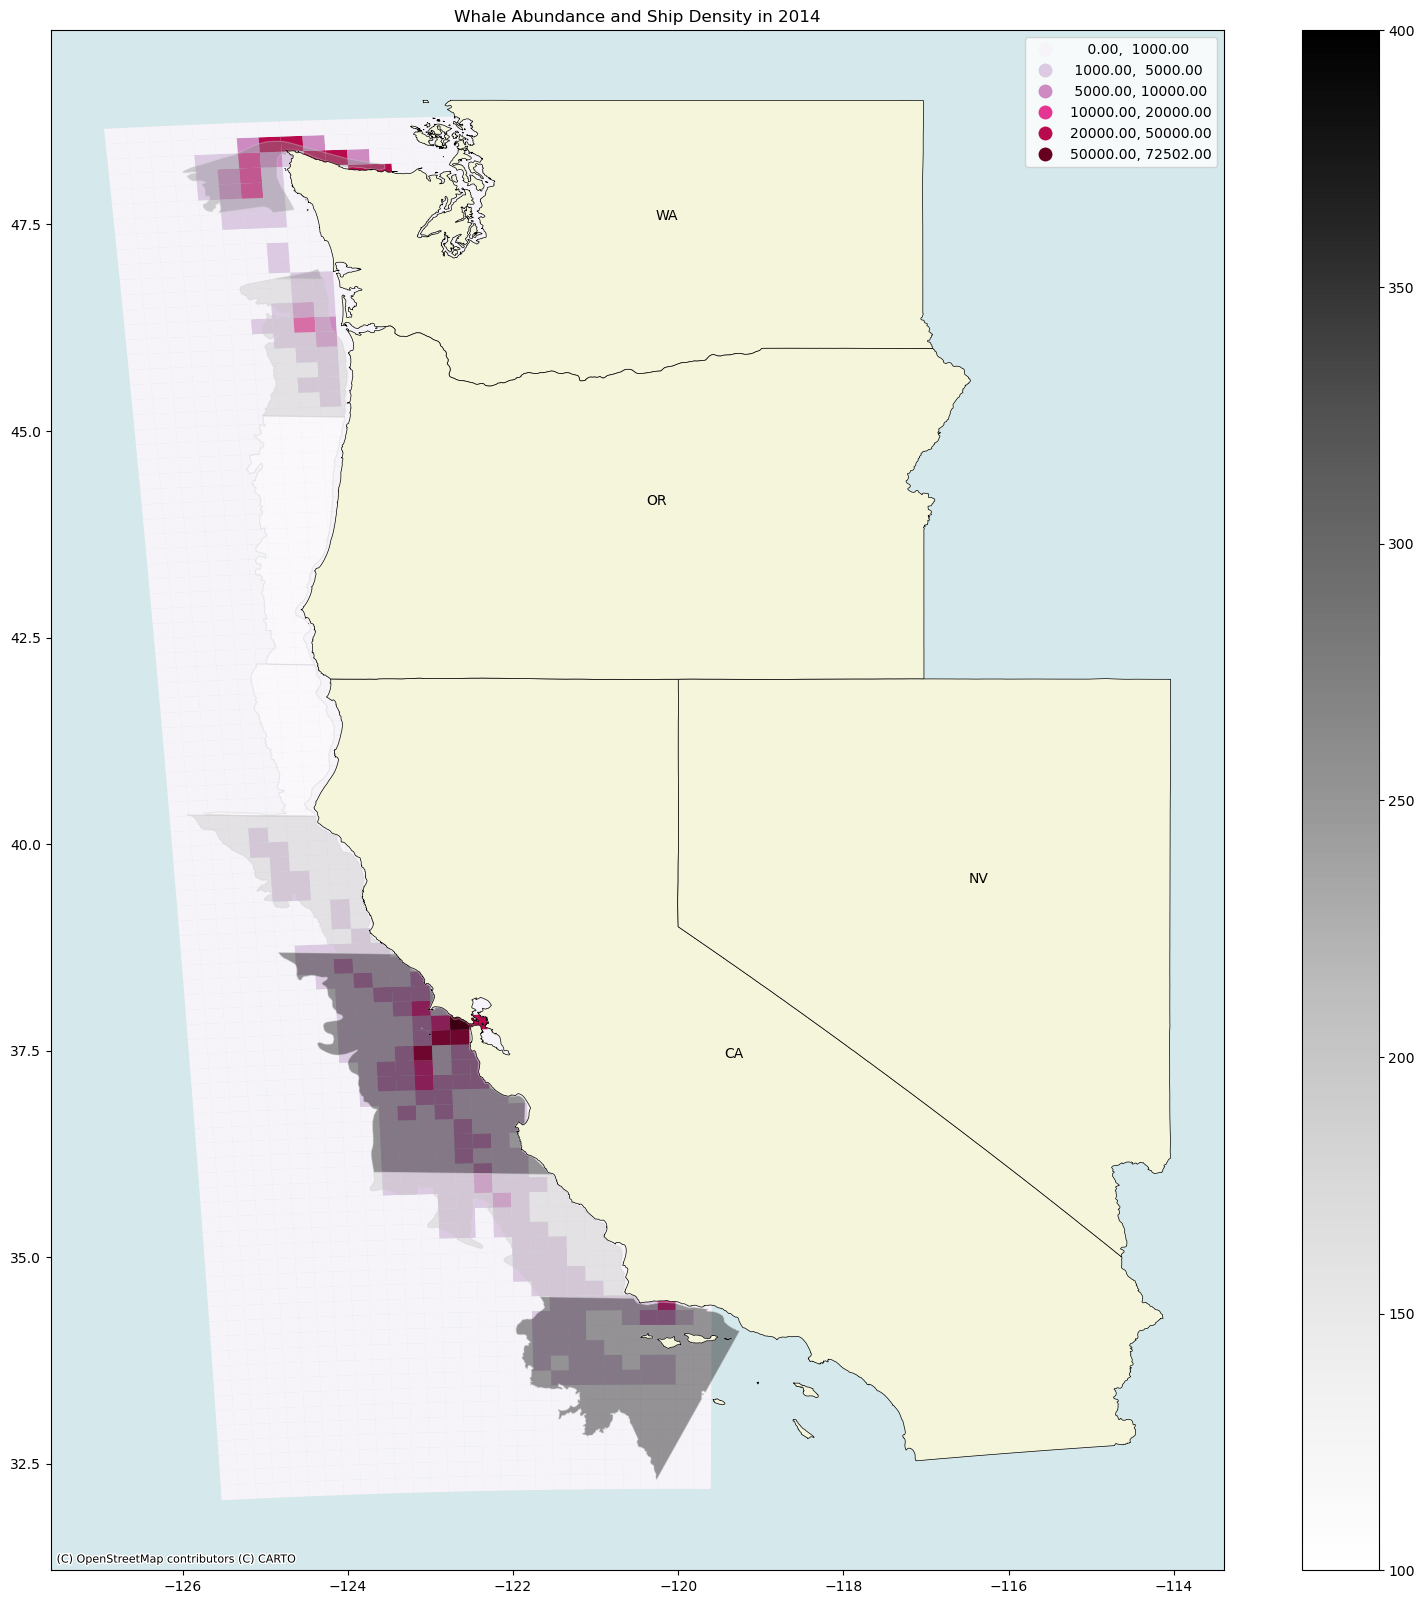

In [44]:
#2014 DENSITY 

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot 2014 ship data
ship_2014_wgs.plot(ax=ax, column="Count", cmap="PuRd", linewidth=0.0, alpha=1, legend=True, scheme='User_Defined', classification_kwds=class_bins)

# Plot habitat data
whale_wgs.plot(column='2014', cmap='Greys', linewidth=0.8, alpha=0.4, ax=ax, edgecolor='0.8', legend=True)

westcoast_wgs.plot(ax=ax, marker='o', color='beige', edgecolor='black', linewidth=0.5, markersize=1)
# Add labels
for idx, row in westcoast_wgs.iterrows():
    centroid = row['geometry'].centroid
    name = row['STUSPS']
    ax.annotate(name, xy=(centroid.x, centroid.y), xytext=(10, 10), textcoords='offset points')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,zoom = 6, reset_extent = True)
# Set plot title
ax.set_title('Whale Abundance and Ship Density in 2014')


# Save the plot as a JPG file
plt.savefig('result_2014.jpg')

# Display the plot
plt.show()

## Making a GIF from the maps

In [45]:
img_list = ['result_2009.jpg', 'result_2010.jpg', 'result_2011.jpg',
            'result_2012.jpg', 'result_2013.jpg', 'result_2014.jpg']
with imageio.get_writer('final_maps.gif', mode='I', duration=1000, loop=0) as writer:
    for filename in img_list:
        image = imageio.imread(filename)
        writer.append_data(image)

C:\Users\Miles\AppData\Local\Temp\ipykernel_39368\3303364990.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


![final_gif](./final_maps.gif)